In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib notebook

## Read in netCDF data

In [2]:
from scipy.io import netcdf_file

# https://resources.marine.copernicus.eu/product-download/SEALEVEL_EUR_PHY_L4_MY_008_068
f = netcdf_file("data2.nc")
f.variables

{'ugos': <scipy.io._netcdf.netcdf_variable at 0x7f0e0e121780>,
 'vgos': <scipy.io._netcdf.netcdf_variable at 0x7f0e0dc350f0>,
 'vgosa': <scipy.io._netcdf.netcdf_variable at 0x7f0e0dc35120>,
 'crs': <scipy.io._netcdf.netcdf_variable at 0x7f0e0dc351b0>,
 'err_vgosa': <scipy.io._netcdf.netcdf_variable at 0x7f0e0dc35240>,
 'latitude': <scipy.io._netcdf.netcdf_variable at 0x7f0e0dc35300>,
 'nv': <scipy.io._netcdf.netcdf_variable at 0x7f0e0dc35390>,
 'sla': <scipy.io._netcdf.netcdf_variable at 0x7f0e0dc35420>,
 'ugosa': <scipy.io._netcdf.netcdf_variable at 0x7f0e0dc35570>,
 'lat_bnds': <scipy.io._netcdf.netcdf_variable at 0x7f0e0dc355d0>,
 'flag_ice': <scipy.io._netcdf.netcdf_variable at 0x7f0e0dc35660>,
 'adt': <scipy.io._netcdf.netcdf_variable at 0x7f0e0dc35720>,
 'err_ugosa': <scipy.io._netcdf.netcdf_variable at 0x7f0e0dc35780>,
 'tpa_correction': <scipy.io._netcdf.netcdf_variable at 0x7f0e0dc35810>,
 'time': <scipy.io._netcdf.netcdf_variable at 0x7f0e0dc358a0>,
 'longitude': <scipy.io._n

## Extract Lat/Long

In [3]:
lat = f.variables['latitude'].data
long = f.variables['longitude'].data

## Extract Velocity

x component of velocity

<IPython.core.display.Javascript object>


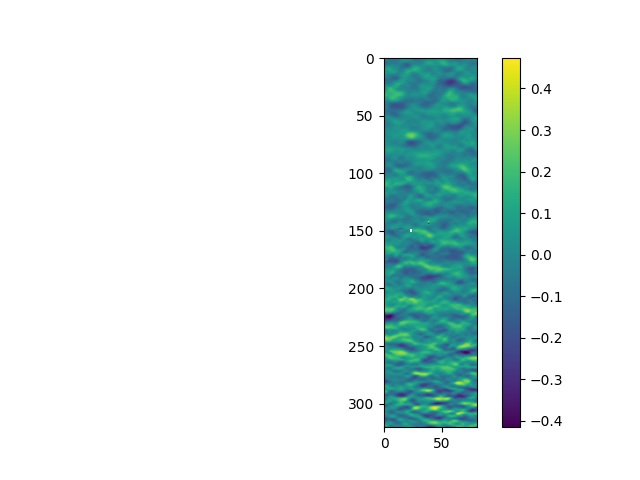

In [4]:
vel_x = f.variables['ugos'].data.squeeze()
vel_x.shape
plt.figure()
plt.imshow(vel_x)
plt.colorbar()

y component of velocity

<IPython.core.display.Javascript object>


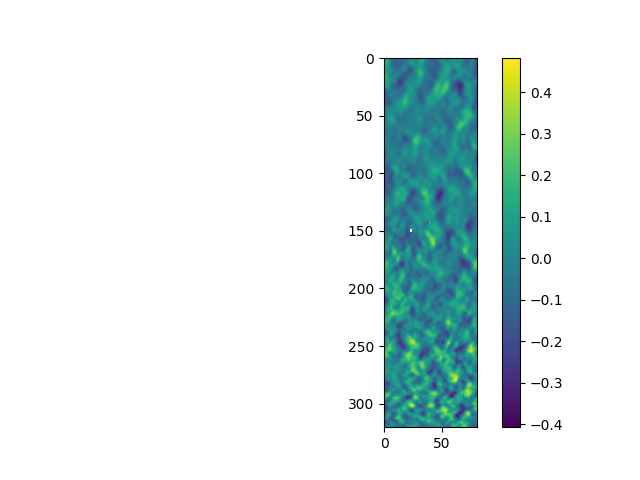

In [5]:
vel_y = f.variables['vgos'].data.squeeze()
vel_y.shape
plt.figure()
plt.imshow(vel_y)
plt.colorbar()

At this point we may need to do some clever projection 

## Are there any missing values?

In [6]:
print(f"Missing values in x: {np.isnan(np.amin(vel_x))}")
print(f"Missing values in y: {np.isnan(np.amin(vel_y))}")

Missing values in x: True
Missing values in y: True


## Impute Missing Values with average value of row for the time being (this should be improved in the future eg. MultivariateImputer or maybe use masked arrays)

In [7]:
from sklearn.impute import SimpleImputer

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imputed_vel_x = imp.fit_transform(vel_x)
imputed_vel_y = imp.fit_transform(vel_y)

## Plot data again to check nothing crazy has happened

<IPython.core.display.Javascript object>


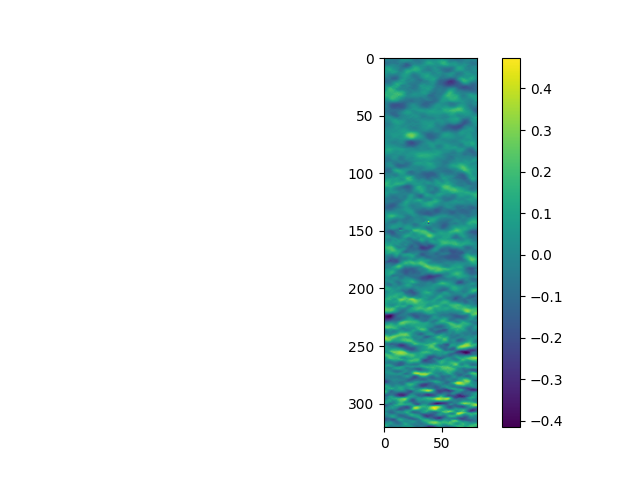

In [8]:
plt.figure()
plt.imshow(imputed_vel_x)
plt.colorbar()

<IPython.core.display.Javascript object>


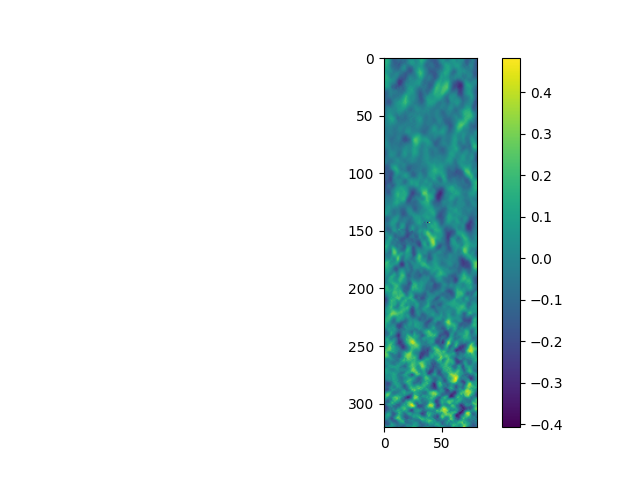

In [9]:
plt.figure()
plt.imshow(imputed_vel_y)
plt.colorbar()

## Quiver Plot

<IPython.core.display.Javascript object>


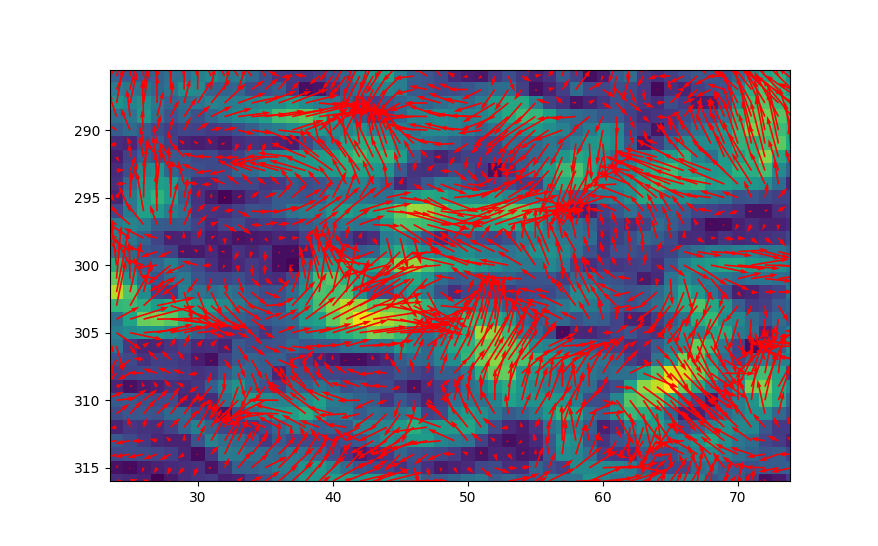

In [10]:
# start with magnitude of velocity as background
plt.figure()
plt.imshow(np.hypot(imputed_vel_x, imputed_vel_y))
plt.quiver(imputed_vel_x, imputed_vel_y, color='r', scale=5)

## Compute curl

Velocity Field $\mathbf{v}(x,y) = (v_x(x,y), v_y(x,y))$

$$
\nabla \times \mathbf{v} = \frac{\partial v_y}{\partial x} - \frac{\partial v_x}{\partial y}
$$

<IPython.core.display.Javascript object>


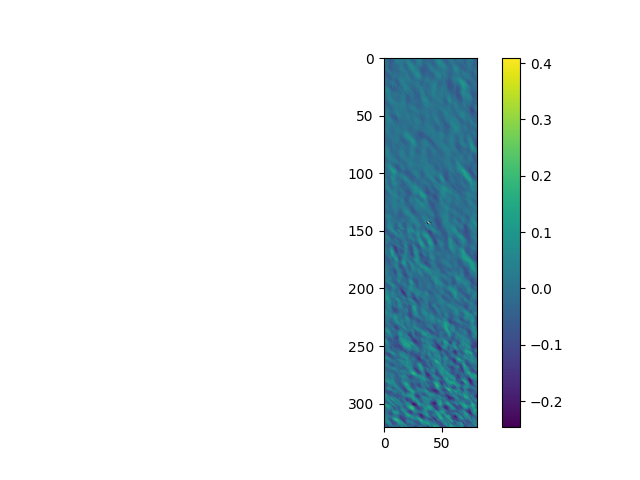

In [11]:
# would probably be good to compute the correct dx and dy
# or maybe we dont have to do this is we do some clever projection?
curl = np.gradient(imputed_vel_y, axis=1) - np.gradient(imputed_vel_y, axis=0)
plt.figure()
plt.imshow(curl)
plt.colorbar()

## Okubo–Weiss parameter
Okubo, A., 1970: Horizontal dispersion of floatable particles in the vicinity of velocity singularities such as convergences. Deep-Sea Res., 17, 445–454

## Thresholding

## Spectral Clustering

## Integrating Particles

$$
\mathbf{x} = (x,y)
$$
$$
\dot{\mathbf{x}} = \mathbf{v}(\mathbf{x})
$$

<IPython.core.display.Javascript object>


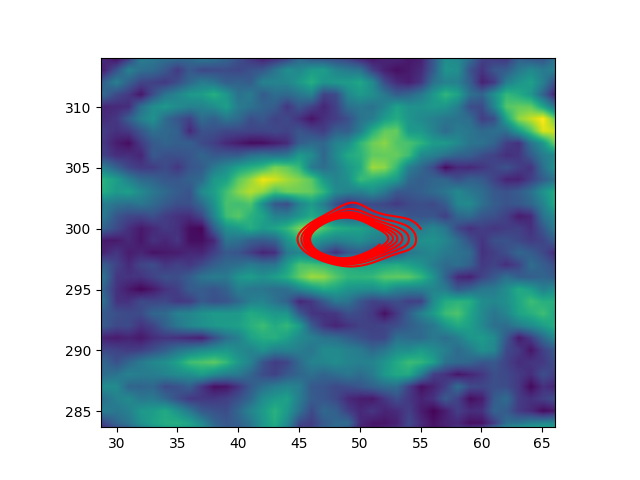

In [63]:
from scipy.interpolate import RegularGridInterpolator
from scipy.integrate import solve_ivp

# first build an interpolator over the x and y velocity
# for now dont use any proper coordinates just [0,m]*[0,n]
m,n = imputed_vel_x.shape
x = np.linspace(0, n, n)
y = np.linspace(0, m, m)

interp_vel_x = RegularGridInterpolator((x, y), vel_x.T)
interp_vel_y = RegularGridInterpolator((x, y), vel_y.T)

def rhs(t, x):
    try:
        return [interp_vel_x(x).squeeze(), interp_vel_y(x).squeeze()]
    except ValueError:
        # particle has left domain
        return [0, 0]
# ics of (50, 300) maybe an eddie?
sol = solve_ivp(rhs, (0, 500), [55, 300], max_step=1)
plt.figure()
plt.imshow(np.hypot(imputed_vel_x, imputed_vel_y), origin='lower', interpolation="bilinear")
plt.plot(sol.y[0], sol.y[1], 'r-')